In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pathlib
import PIL
import matplotlib.pyplot as plt
import seaborn as sb

In [8]:
train_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/train")
val_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/val")
test_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/test")

In [9]:
image_count = len(list(train_path.glob("*/*.jpeg")))
image_count

5216

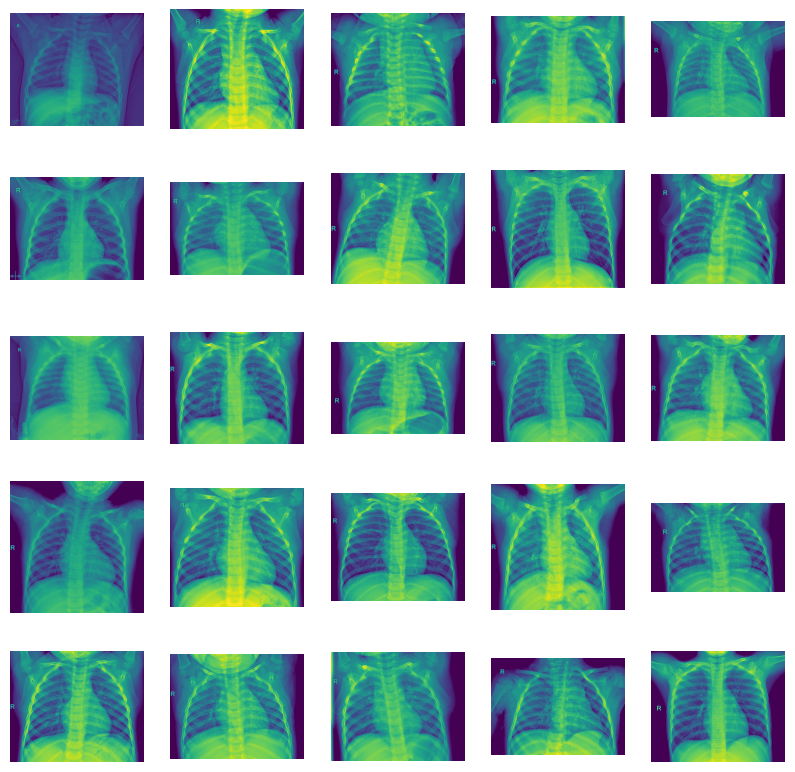

In [10]:
normal_vis = list(train_path.glob("NORMAL/*.jpeg"))
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = PIL.Image.open(str(normal_vis[i]))
    plt.imshow(img)
    plt.axis(False)
    

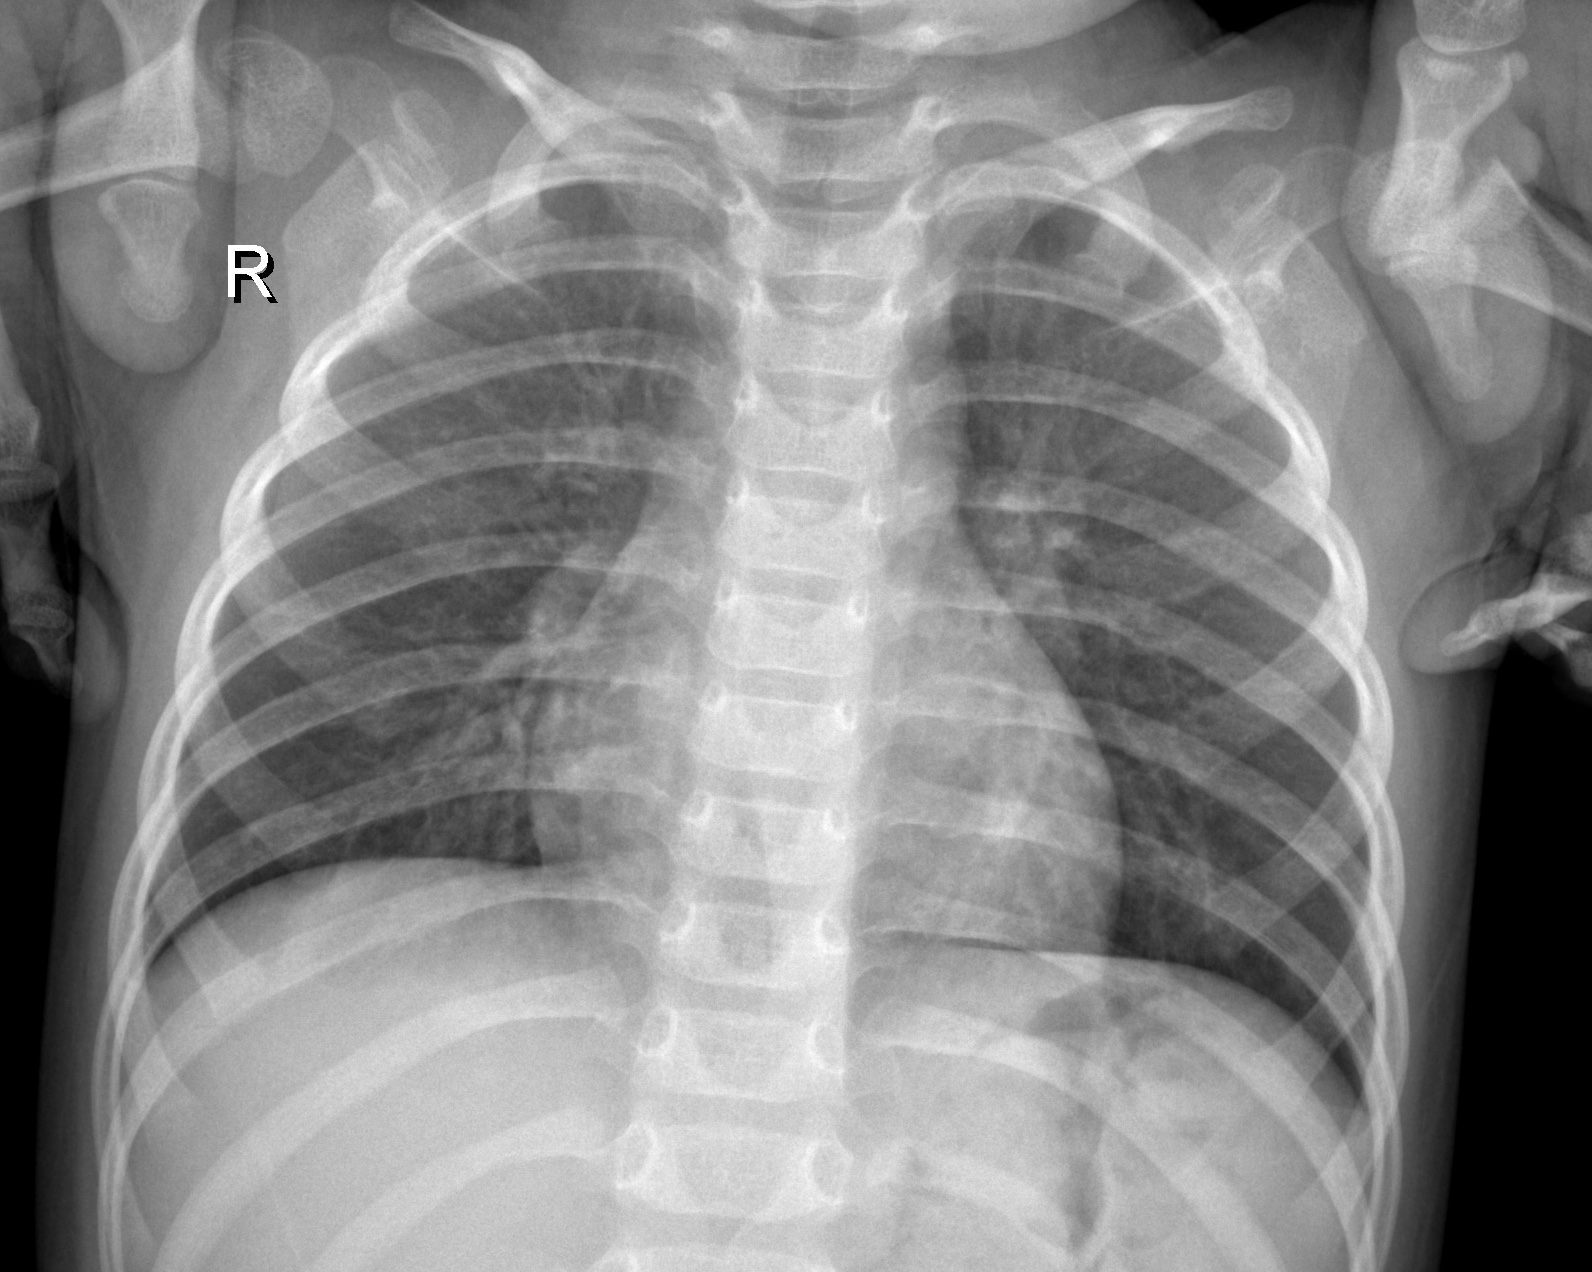

In [11]:
PIL.Image.open(str(normal_vis[-1]))

In [16]:
batch_size = 100
image_width = 128
image_height = 128
random_state = 100

In [17]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


NameError: name 'class_names' is not defined

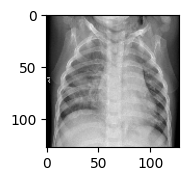

In [14]:
plt.figure(figsize = (10, 10))
for images, labels in train_data.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis(False)

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)]
)

In [19]:
data_preprocessing_resnet = tf.keras.applications.resnet.preprocess_input

base_model_resnet = tf.keras.applications.resnet.ResNet50(
    input_shape = (image_height, image_width, 3),
    include_top = False,
    weights = "imagenet"
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
base_model_resnet.trainable = False

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation = "sigmoid")

In [22]:
inputs = tf.keras.Input((128, 128, 3))
x = data_augmentation(inputs)
x = data_preprocessing_resnet(x)
x = base_model_resnet(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

In [23]:
model_resnet = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

In [24]:
model_resnet.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)

In [29]:
history_resnet = model_resnet.fit(train_data, validation_data = val_data, batch_size = 100, epochs = 10, callbacks=[early_stopping])

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9373 - loss: 0.5075 - val_accuracy: 0.8125 - val_loss: 1.6458
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.9327 - loss: 0.6570 - val_accuracy: 0.8750 - val_loss: 0.7348
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9404 - loss: 0.4518 - val_accuracy: 0.8125 - val_loss: 1.3279
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.9407 - loss: 0.4335 - val_accuracy: 0.6250 - val_loss: 3.3899
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9446 - loss: 0.4389 - val_accuracy: 0.8750 - val_loss: 1.3319


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

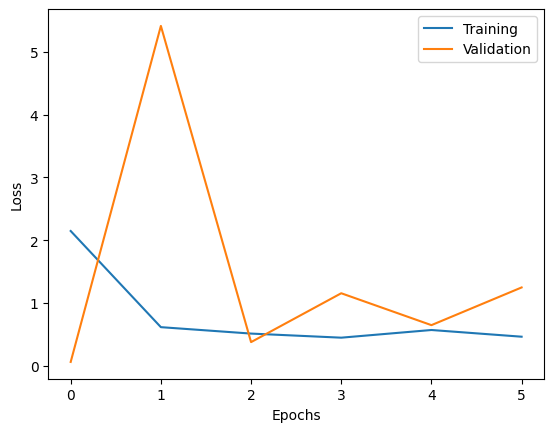

In [27]:
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["loss"], label = "Training")
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["val_loss"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [2]:
PLotting the graph between epochs loss for accuracy and val_accuracy

sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["accuracy"], label = "Training")
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["val_accuracy"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")

SyntaxError: invalid syntax (4119322843.py, line 1)

In [3]:
# Evaluate the model
result_resnet = model_resnet.evaluate(test_data)
print(f"Loss: {result_resnet[0]}")
print(f"Accuracy: {result_resnet[1] * 100}")

NameError: name 'model_resnet' is not defined

In [4]:
model_resnet.save("my_model.h5")

NameError: name 'model_resnet' is not defined

In [5]:
import keras

2024-03-01 11:17:48.702639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 11:17:48.702783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 11:17:48.847678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
keras.models.load_model('my_model.h5')